# Assignment-2: Manifold Learning

The objective of this assignment is to apply the concepts you have learned in class on Manifold Learning and Spectral Clustering. 

## Instructions
  - For each question you need to write the sub-problem formulation in markdown. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagiarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file.

__NOTE__: If you use online platforms, you will have to upload `swissroll.dat` file separately and change the path in the code cell which loads the data.

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
 - Question 1: Spectral Clustering (10 marks)
 - Question 2: Manifold Visualization (10 marks)
 - Question 3: Clustering and Visualizing high-dimensional data (10 marks)
 - Question 4: Classification (10 marks)

## Deadline 
The deadline of this assignment is 27th April, 2020, 11:59 PM

In [1]:
import sys
# Install packages correctly
!{sys.executable} -m pip install numpy sklearn tensorflow keras
# Fix mpl version due to subtle API differences
!{sys.executable} -m pip install matplotlib==3.0.3

import numpy
# Allow usage of both `np` and `numpy`
np = numpy
import sklearn
import matplotlib.pyplot as plt

# Question 1: Spectral Clustering

Implement spectral clustering and evaluate on the given concentric circles dataset for this question.

## Part 1: Implementation
Implement spectral clustering function from scratch (for two clusters), taking as input the dataset. It must return the predicted clustering. Assume that the graph constructed is a fully connected graph. Use the normalized graph laplacian for this case.



In [0]:
# Part 1: Spectral Clusteringfrom sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import euclidean_distances 
def spectral_clustering(X):
  Adj = euclidean_distances(X)
  np.fill_diagonal(Adj,0)
  W = np.exp((Adj)*(-0.5/(0.1*0.1)))
  np.fill_diagonal(W, 0)
  Deg = np.diag(W.sum(axis=1))
  #create laplacian
  Lap = Deg-W
  Deg_inv_sqrt = np.linalg.pinv(np.sqrt(Deg))
  Normal_lap = np.dot(Deg_inv_sqrt, np.dot(Lap, Deg_inv_sqrt))
  eval, evec = np.linalg.eig(Normal_lap)
  #sort
  evec = evec[:,np.argsort(eval)]
  eval = eval[np.argsort(eval)]
  #fiedler values to separate the data
  Y_pred = evec[:,1] > 0
  return Y_pred
  
    
  
  # Your code here
#   return Y_pred


## Part 2: Clustering concentric circles
Perform spectral clustering on the concentric circles dataset. Visualize the result by plotting it on a 2-d graph. Use different colours for different clusters.

In [0]:
# DO NOT EDIT

from sklearn.datasets import make_circles 

CX, CY = make_circles(n_samples=200, shuffle=True,noise=0.05, random_state=1337, factor=0.5)
# CX: input data points [n_samples, 2]
# CY: true clusters [n_samples]

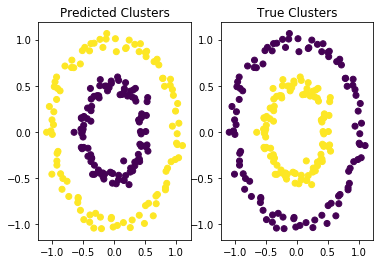

In [4]:
# Part 2: Perform Spectral Clustering on the concentric circles dataset
# Plot using colors from CY (true clusters) and CY_pred (predicted clusters)
# Code in this cell should plot 2 subplots (true labels and predicted labels)
Y_pred = spectral_clustering(CX)

fig = plt.figure()
ax = fig.add_subplot("121")
ax.set_title("Predicted Clusters")
ax.scatter(CX[:, 0], CX[:, 1], c = Y_pred)

ax1 = fig.add_subplot("122")
ax1.set_title("True Clusters")
ax1.scatter(CX[:, 0], CX[:, 1], c = CY)

plt.show()
    

## Part 3: Evaluate accuracy
Evaluate the accuracy of the clustering by comparing it with the true labels. Create two subplots (true vs predicted) with the color of each point showing the cluster label.

In [5]:
# Part 3: Report the accuracy of clustering
acc = 0
for i in range(CX.shape[0]):
    if CY[i] != Y_pred[i]: #opp labels
        acc+=1
print("Accuracy is ",(acc/CX.shape[0])*100)

Accuracy is  100.0




---



# Question 2: Manifold Visualization
Implement the various manifold learning methods and visualize the given datasets.


## Part 1: MDS
Implement Multi-Dimensional Scaling

In [0]:
# Part 1: MDS
from sklearn.metrics.pairwise import euclidean_distances 
def MDS(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  N = X.shape[0]
  D = euclidean_distances(X)
  e = np.ones(N)
  I = np.identity(N)
  e = np.ones(N).reshape((N,1))
  e_t = np.ones(N).reshape((1,N))
  H = I-(1/N)*np.matmul(e,e_t)
  K = (-1/2)*np.matmul(H,np.matmul(D,H))
  eval, evec = np.linalg.eigh(K)
  idx = np.argsort(-(eval))
  vec = evec[:,idx[0:output_dim]]
  val = eval[idx[0:output_dim]]
  Y = np.sqrt(val)*vec
  
  
  # Your code here
  return Y

## Part 2: LLE
Implement Locally Linear Embedding function

In [0]:
# Part 2: LLE
from sklearn.neighbors import NearestNeighbors as NN 
def LLE(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  N = X.shape[0]
  dim = X.shape[1]
  nbs = NN(n_neighbors=k+1).fit(X)
  dist, indices = nbs.kneighbors(X)
  idx = indices[:,1:]
  e = np.ones(k).reshape((k,1))
  e_t = np.ones(k).reshape((1,k))
  W = np.zeros((N,N))
  for i in range(N):
      X_t = X[i].reshape((dim,1))
      V = np.transpose(X[idx[i]])
      G1 = np.matmul(X_t,e_t)-V
      G = np.matmul(np.transpose(G1),G1)
      w = np.matmul(np.linalg.pinv(G),e)
      w = w/(np.sum(w))
      w = w.reshape(-1)
      W[idx[i],i] = w
  I = np.identity(N)
  M = np.matmul(I-W,np.transpose(I-W))
  eval, evec = np.linalg.eigh(M)
  idx = np.argsort(eval)
  evec = evec[:,idx]
  Y = evec[:,1:output_dim+1]
 
  # Your code here
  return Y
# LLE(SX,2,2)

## Part 3: ISOMAP
Implement Isomap Visualization  

In [0]:
# Part 3: Isomap
from sklearn.utils.graph_shortest_path import graph_shortest_path as short_path
from sklearn.neighbors import kneighbors_graph
def ISOMAP(X, k, output_dim=2):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    Y: numpy.array [n_samples, output_dim]
  """
  # Your code here
  N = X.shape[0]
  Adj = kneighbors_graph(X,n_neighbors=k,mode='distance').toarray()
  sp = short_path(Adj,directed=False)
  sp = sp*sp
  e = np.ones(N)
  I = np.identity(N)
  e = np.ones(N).reshape((N,1))
  e_t = np.ones(N).reshape((1,N))
  H = I-(1/N)*np.matmul(e,e_t)
  K = (-1/2)*np.matmul(H,np.matmul(sp,H))
  eval, evec = np.linalg.eigh(K)
  idx = np.argsort(-(eval))
  vec = evec[:,idx[0:output_dim]]
  val = eval[idx[0:output_dim]]
  Y = np.sqrt(val)*vec

  return Y

## Part 3: Manifold Visualization
Visualize the S-shaped 3-d dataset using the MDS, ISOMAP, LLE

In [0]:
# DO NOT EDIT

from sklearn import manifold, datasets

SX, St = datasets.make_s_curve(n_samples=1000, random_state=1337)
# SX: input data [n_samples, 3]
# St: univariate position along manifold [n_samples], use for coloring the plots

The code in the next cell should draw a single plot with the following subplots:
1. 3D S-shaped dataset
2. 2D Manifold learnt using MDS
3. 2D Manifold learnt using ISOMAP
4. 2D Manifold learnt using LLE

Use the `St` variable to color the points in your visualizations. Use a color spectrum, and the position along the manifold to assign the color.

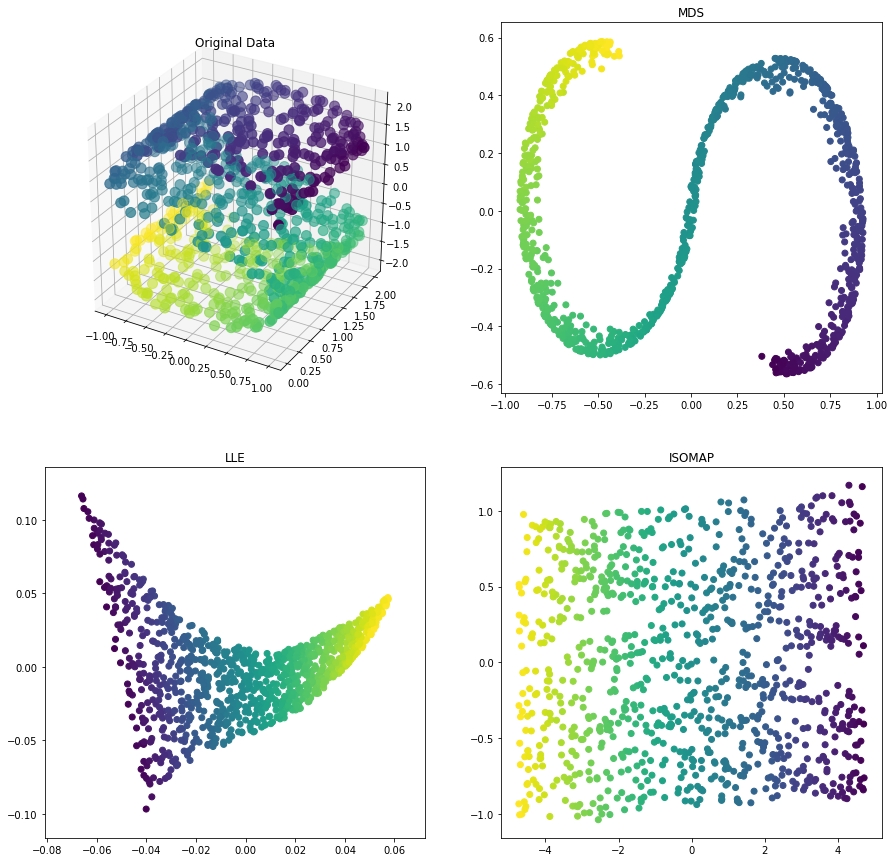

In [10]:
#  Visualization code here
fig = plt.figure(figsize=(15,15))
from mpl_toolkits.mplot3d import Axes3D

###Original Data
ax1 = fig.add_subplot("221",projection='3d')
ax1.set_title("Original Data")
ax1.scatter(SX[:,0],SX[:,1],SX[:,2],c=St,s=100)

##MDS
Y = MDS(SX,2)
ax2 = fig.add_subplot("222")
ax2.set_title("MDS")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)

##LLE
Y = LLE(SX,20)
ax2 = fig.add_subplot("223")
ax2.set_title("LLE")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)

##ISOMAP
Y = ISOMAP(SX,20)
ax2 = fig.add_subplot("224")
ax2.set_title("ISOMAP")
ax2.scatter(Y[:, 0], Y[:, 1], c = St)


plt.show()


# Question 3: Clustering and Visualizing high-dimensional data
Perform k-means and spectral clustering on the Swiss roll dataset and visualize using the above 3 methods. State your observations.

In [11]:
# Swiss roll dataset loading here
from sklearn.cluster import KMeans

d = []
with open('./swissroll.dat', 'r') as dat_file:
    for line in dat_file:
        line = line.strip().split()
        line = [float(x.strip()) for x in line]
        d.append(line)
swissroll = numpy.array(d)
print (swissroll.shape)

(1600, 3)


Procedure for this question:
1. Perform spectral clustering (2 clusters) on the unchanged Swiss roll and visualize (binary colors)
2. Unwrap the manifold in 2D and visualize using
  - MDS
  - ISOMAP
  - LLE

Use the labels from the spectral clustering to color the unwrapped manifolds.

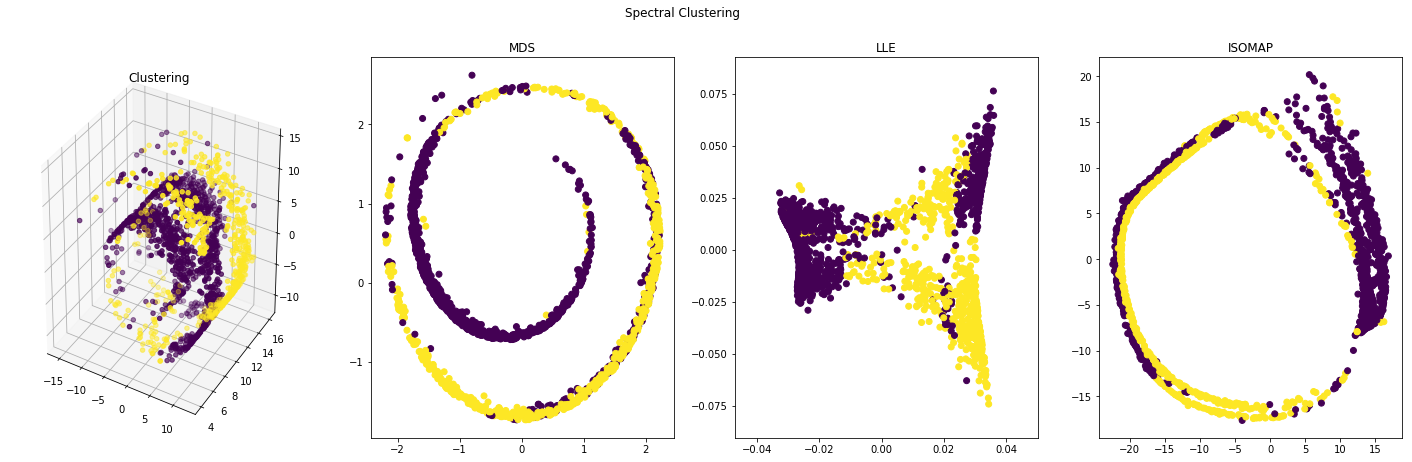

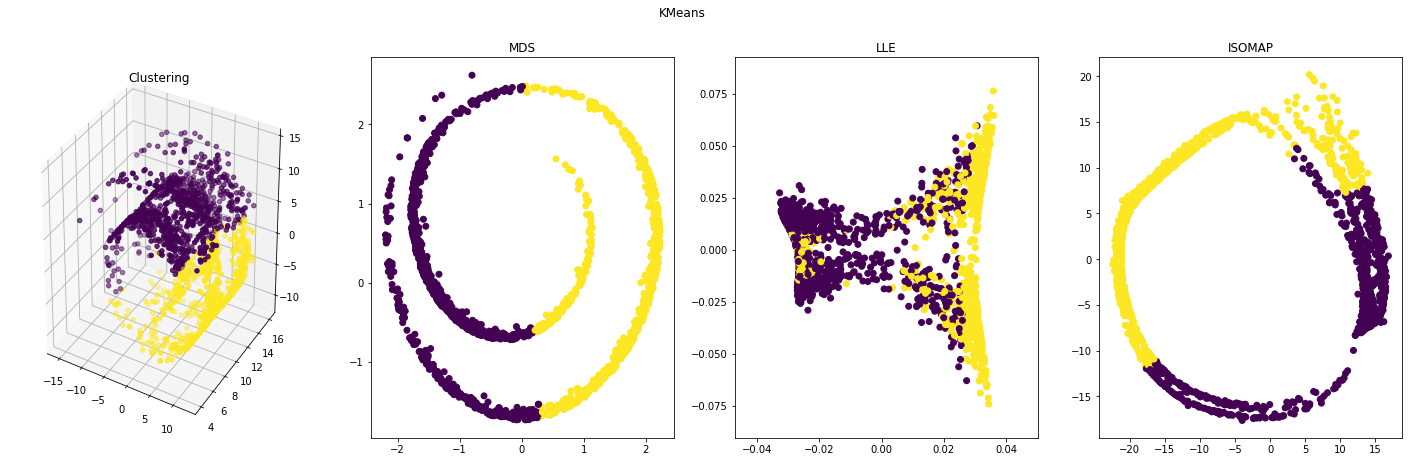

In [12]:
# CODE HERE
##spectral_clustering
SR = spectral_clustering(swissroll)
fig = plt.figure(figsize=(25,7))
fig.suptitle("Spectral Clustering")
ax1 = fig.add_subplot("141",projection='3d')
ax1.set_title("Clustering")
ax1.scatter(swissroll[:,0],swissroll[:,1],swissroll[:,2],c=SR)

###MDS
Y_mds = MDS(swissroll,2)
ax2 = fig.add_subplot("142")
ax2.set_title("MDS")
ax2.scatter(Y_mds[:, 0], Y_mds[:, 1], c = SR)

##LLE
Y_lle = LLE(swissroll,25)
ax2 = fig.add_subplot("143")
ax2.set_title("LLE")
ax2.scatter(Y_lle[:, 0], Y_lle[:, 1], c = SR)

##ISOMAP
Y_isomap = ISOMAP(swissroll,25)
ax2 = fig.add_subplot("144")
ax2.set_title("ISOMAP")
ax2.scatter(Y_isomap[:, 0], Y_isomap[:, 1], c = SR)


##Kmeans
kmeans = KMeans(n_clusters=2).fit(swissroll)
klabels = kmeans.labels_
fig = plt.figure(figsize=(25,7))
fig.suptitle("KMeans")
ax1 = fig.add_subplot("141",projection='3d')
ax1.set_title("Clustering")
ax1.scatter(swissroll[:,0],swissroll[:,1],swissroll[:,2],c=klabels)


###MDS
ax2 = fig.add_subplot("142")
ax2.set_title("MDS")
ax2.scatter(Y_mds[:, 0], Y_mds[:, 1], c = klabels)

##LLE
Y = LLE(swissroll,15)
ax2 = fig.add_subplot("143")
ax2.set_title("LLE")
ax2.scatter(Y_lle[:, 0], Y_lle[:, 1], c = klabels)

##ISOMAP
Y = ISOMAP(swissroll,15)
ax2 = fig.add_subplot("144")
ax2.set_title("ISOMAP")
ax2.scatter(Y_isomap[:, 0], Y_isomap[:, 1], c = klabels)





plt.show()

#### Swissroll data has a hole in the center which induces non-convexity and hence makes it difficult for the manifold learning methods to unfold the data along the manifold.

#### Clustering on 3D Swissroll
- Kmeans clustering gives undesirable results as it does not classify the datapoints along the manifold
- In case of Spectral clustering, the datapoints are classified along the manifold which gives accurate classification

#### 2D VIsualization of Swissroll Data
- MDS cannot unroll the swissroll, as no information related to manifold is incorporated during dimensionality reduction
- ISOMAP and LLE finds the hole but this distorts the unfolding of the set
- Spectral Clustering on the 2D data separates the datapoints along the manifold accurately as compared to Kmeans clustering




---



# Question 4: Classification

Perform classification using a machine learning algorithm of your choice. Use 6k images from CIFAR-10 dataset.(5k images for training and 1k images for testing.)


*   Do dimensionality reduction on the dataset using PCA and ISOMAP.
*   Apply the classification algorithm.
*   Compare the results by changing the dimensionality of the data.
*   Use F1-score as metric.
*   Approach: Reduce the dimensionality into any two dimensions(of your choice) which are less than the initial dimensionality of the data using PCA and ISOMAP. Compare the performance metrics(F1-score) for the low dimensional data.



In [13]:
# Code for loading CIFAR-10 dataset.
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:5000].reshape([5000,32*32*3])
y_train = y_train[:5000].reshape(-1)
X_test = X_test[:1000].reshape([1000,32*32*3])
y_test = y_test[:1000].reshape(-1)
# Initial dimensionality/number of features (32*32*3) = 3072.

Using TensorFlow backend.


170500096/170498071 [==============================] - 5s 0us/step


In [0]:
from sklearn.decomposition import PCA
def reductionUsingPCA(X, k, output_dim):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    pca_X: numpy.array [n_samples, output_dim]
  """
  # Enter your code here
  pca_X = PCA(n_components = output_dim).fit(X)
  return pca_X

In [0]:
from sklearn.manifold import Isomap
def reductionUsingISOMAP(X, k, output_dim):
  """Args:
    X: numpy.array [n_samples, input_dim]
    k: number of nearest neighbours to construct the knn graph
    output_dim: dimension of output data

    Returns:
    isomap_X: numpy.array [n_samples, output_dim]
  """
  isomap_X = Isomap(n_components=output_dim, n_neighbors = k).fit(X)
  # Enter your code here
  return isomap_X

In [0]:
# Classification Algorithm 
# Extra functions here
from sklearn import svm
def classification(X ,c_classes,model1):
  """Args:
    X: numpy.array [n_samples, input_dim]
    n_classes: number of classes

    Returns:
    labels: numpy_array [n_samples]
  """
  # Your code here
  labels = model1.predict(X)
  return labels



In [0]:
from sklearn.metrics import f1_score
def F1_score(y_true, y_pred):
  """Args:
    y_true: numpy.array [n_samples] , ground truth value
    y_pred: numpy.array [n_samples] , predicted value by classifier
    
    Returns:
    score: float, f1-score
  """
  score = f1_score(y_true, y_pred, average = "micro")
  return score


In [0]:
def calculate_score_PCA(X_train,y_train,X_test,y_test,dim):
  pca = reductionUsingPCA(X_train,100,dim)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  clf = svm.SVC()
  model_1 = clf.fit(X_train_pca,y_train)
  y_pred_pca = classification(X_test_pca,100, model_1)
  print("F1 - Score for PCA",F1_score(y_test,y_pred_pca))


In [0]:
def calculate_score_Isomap(X_train,y_train,X_test,y_test,dim):
  iso = reductionUsingISOMAP(X_train,100,dim)
  X_train_iso = iso.transform(X_train)
  X_test_iso = iso.transform(X_test)
  clf = svm.SVC()
  model_1 = clf.fit(X_train_iso,y_train)
  y_pred_iso = classification(X_test_iso,100, model_1)
  print("F1 - Score for ISOMAP",F1_score(y_test,y_pred_iso))


In [20]:
print("dim = ",100)
calculate_score_PCA(X_train,y_train,X_test,y_test,100)
print("dim = ",500)
calculate_score_PCA(X_train,y_train,X_test,y_test,500)

dim =  100
F1 - Score for PCA 0.422
dim =  500
F1 - Score for PCA 0.427


In [21]:
print("dim = ",100)
calculate_score_Isomap(X_train,y_train,X_test,y_test,100)
print("dim = ",500)
calculate_score_Isomap(X_train,y_train,X_test,y_test,500)

dim =  100
F1 - Score for ISOMAP 0.354
dim =  500
F1 - Score for ISOMAP 0.342


#### Dimensions used for Dimensionality Reduction 100 and 500. 
* F1-score of PCA is more than F1-score of IsoMap. This is due the fact that ISOMAP performs dimensionality reduction based on the fact that data in lower dimensions is very close to data in higher dimensions. However since we are performing classification, data in lower dimensions should be well separable and PCA is better when it comes to preserving inter class variance.
* Since CIFAR data doesn't lie on manifold, Therefore, ISOMAP would'nt be of much use.
* F1-score for higher dimensions is greater than that of lower dimensions(For PCA) which is also true since reconstruction error is less than that of higher dimension.
* F1-score in case of ISOMAP decreases a bit with higher dimension. 
